In [ ]:
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score


#  EDA - Part A: Feature Correlation & Impact Analysis

This section investigates the "Order of Influence" of different physical drivers on the streamflow.
* **Correlation Matrix**: Uses Spearman correlation (non-linear) to check how strongly variables like **Precipitation**, **Soil Moisture**, and **Temperature** relate to **Streamflow**.
* **Goal**: To confirm that the physical inputs we chose (Rain, Soil Water) are actually predictive of floods in this specific region.

* **Missing Data Investigation**: We checked for Null values in both the target (`streamflow`) and the explanatory variables. We found that **missing values are predominantly in the Streamflow data**, while satellite-derived features (Rain, Temperature) are complete. This led to our specific investigation of "Suspicious Days" ensuring that sensor failures during heavy rain events do not mislead the model.

Starting Enhanced EDA for 3 basins...



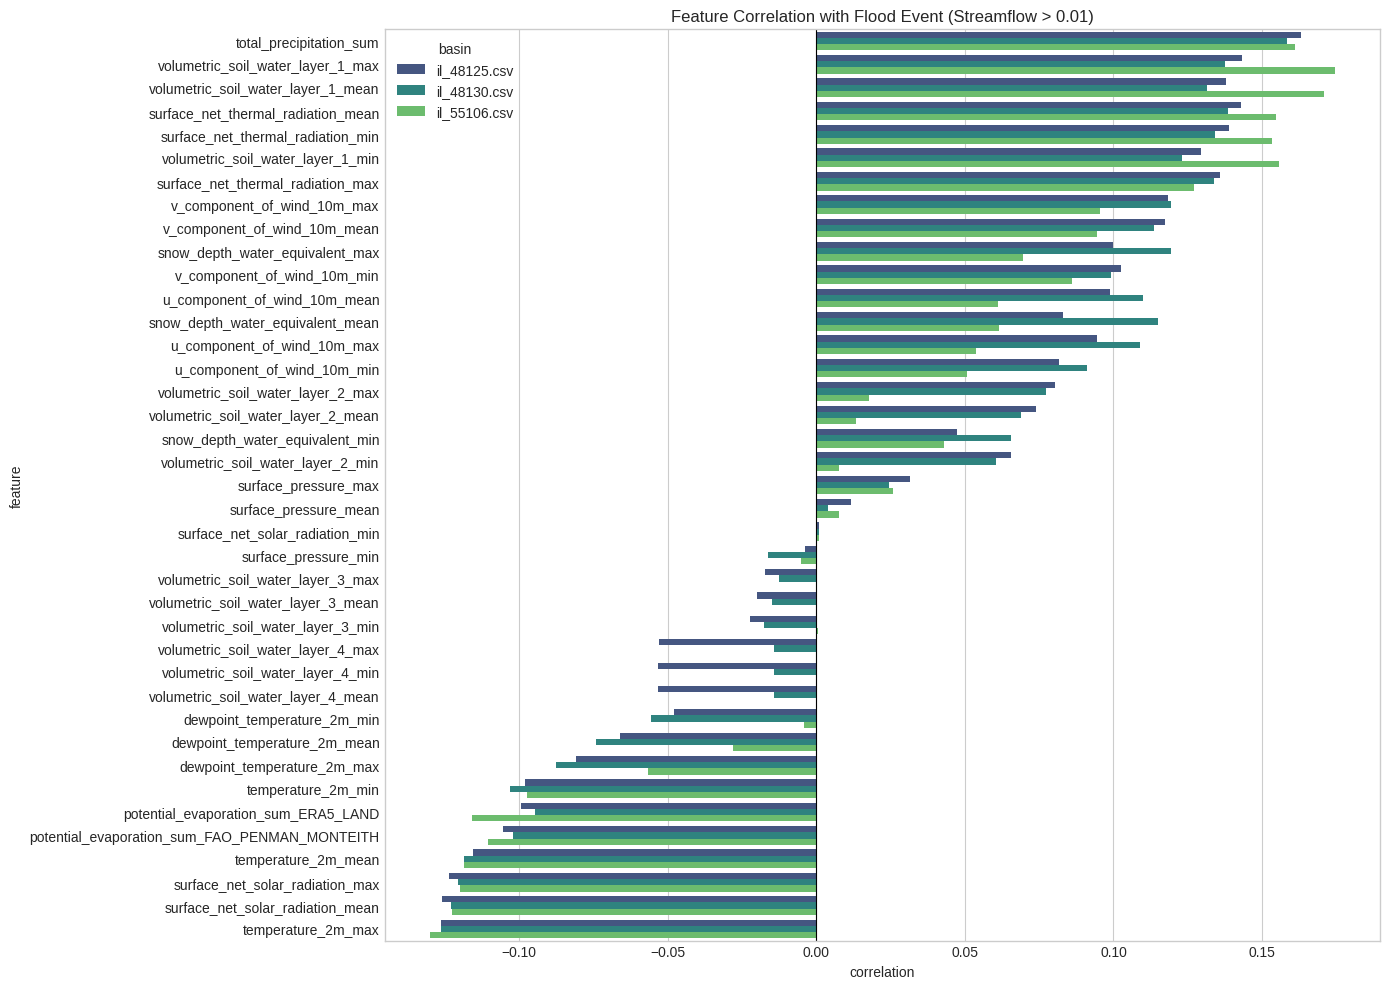


DATA LOGIC & QUALITY REPORT (Sanity Checks)

BASIN: il_48125.csv
  1. Rainy days (> 5.0mm) with MISSING Streamflow (NaN): 800 days
     Examples: [datetime.date(1950, 1, 9), datetime.date(1950, 1, 12), datetime.date(1950, 1, 13), datetime.date(1950, 1, 14), datetime.date(1950, 1, 15)]...
  2. Heavy Rain (> 20.0mm) with ZERO Streamflow (0.0): 12 days
     Examples: [datetime.date(1991, 3, 22), datetime.date(1997, 10, 18), datetime.date(1998, 1, 11), datetime.date(2000, 1, 27), datetime.date(2002, 12, 20)]...
     * Warning: These might be sensor errors or measurement artifacts.

BASIN: il_48130.csv
  1. Rainy days (> 5.0mm) with MISSING Streamflow (NaN): 769 days
     Examples: [datetime.date(1950, 1, 9), datetime.date(1950, 1, 12), datetime.date(1950, 1, 13), datetime.date(1950, 1, 14), datetime.date(1950, 1, 15)]...
  2. Heavy Rain (> 20.0mm) with ZERO Streamflow (0.0): 12 days
     Examples: [datetime.date(1991, 3, 22), datetime.date(1998, 1, 11), datetime.date(2000, 1, 27), datetim

In [ ]:

# Configuration
BASIN_FILES = ['il_48125.csv', 'il_48130.csv', 'il_55106.csv']
FLOOD_THRESHOLD = 0.01
RAIN_THRESHOLD_FOR_MISSING = 5.0  # mm (Threshold to check for missing streamflow)
HEAVY_RAIN_THRESHOLD = 20.0       # mm (Threshold to check for suspicious zero flow)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)

# Storage
correlation_results = []
null_analysis_frames = []
variability_results = []
sanity_check_results = []

print(f"Starting Enhanced EDA for {len(BASIN_FILES)} basins...\n")

for file_name in BASIN_FILES:
    # 1. Load Data
    try:
        df = pd.read_csv(file_name)
        df['date'] = pd.to_datetime(df['date'])
    except FileNotFoundError:
        print(f"File {file_name} not found. Skipping.")
        continue

    # SANITY / LOGIC CHECKS (New Section) ---

    # Check 1: Significant Rain (>5mm) but Streamflow is NaN (Missing Label)
    missing_flow_mask = (df['total_precipitation_sum'] > RAIN_THRESHOLD_FOR_MISSING) & (df['streamflow'].isna())
    missing_flow_days = df[missing_flow_mask].copy()

    # Check 2: Heavy Rain (>20mm) but Streamflow is exactly 0.0 (Suspicious Measurement)
    # We only check rows where streamflow is NOT NaN
    suspicious_zero_mask = (df['total_precipitation_sum'] > HEAVY_RAIN_THRESHOLD) & (df['streamflow'] == 0.0)
    suspicious_zero_days = df[suspicious_zero_mask].copy()

    # Store results
    if not missing_flow_days.empty or not suspicious_zero_days.empty:
        sanity_check_results.append({
            'basin': file_name,
            'missing_flow_count': len(missing_flow_days),
            'suspicious_zero_count': len(suspicious_zero_days),
            'missing_flow_dates': missing_flow_days['date'].dt.date.tolist()[:5], # Show first 5
            'suspicious_zero_dates': suspicious_zero_days['date'].dt.date.tolist()[:5]
        })

    # --- Standard EDA (Correlation & Noise) ---

    # Filter for valid targets for correlation analysis
    df_clean = df.dropna(subset=['streamflow']).copy()
    df_clean['is_flood'] = (df_clean['streamflow'] > FLOOD_THRESHOLD).astype(int)

    feature_cols = [c for c in df_clean.columns if c not in ['date', 'streamflow', 'is_flood']]

    # Correlation
    corr = df_clean[feature_cols + ['is_flood']].corr(method='spearman')['is_flood'].drop('is_flood')
    corr_df = corr.to_frame(name='correlation')
    corr_df['basin'] = file_name
    correlation_results.append(corr_df)

    # Variability Analysis (Noise)
    std_df = df_clean.groupby('is_flood')[feature_cols].std().T
    std_df.columns = ['Non_Flood_Std', 'Flood_Std']
    std_df['Noise_Ratio'] = std_df['Flood_Std'] / std_df['Non_Flood_Std']
    std_df['basin'] = file_name
    variability_results.append(std_df)

# --- Visualization ---
if correlation_results:
    all_corrs = pd.concat(correlation_results).reset_index().rename(columns={'index': 'feature'})
    plt.figure(figsize=(14, 10))
    order = all_corrs.groupby('feature')['correlation'].mean().sort_values(ascending=False).index
    sns.barplot(data=all_corrs, y='feature', x='correlation', hue='basin', order=order, palette='viridis')
    plt.title(f'Feature Correlation with Flood Event (Streamflow > {FLOOD_THRESHOLD})')
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()

# --- Print Reports ---

print("\n" + "="*60)
print("DATA LOGIC & QUALITY REPORT (Sanity Checks)")
print("="*60)

if not sanity_check_results:
    print("No illogical data points found based on current thresholds.")
else:
    for res in sanity_check_results:
        print(f"\nBASIN: {res['basin']}")
        print(f"  1. Rainy days (> {RAIN_THRESHOLD_FOR_MISSING}mm) with MISSING Streamflow (NaN): {res['missing_flow_count']} days")
        if res['missing_flow_count'] > 0:
            print(f"     Examples: {res['missing_flow_dates']}...")

        print(f"  2. Heavy Rain (> {HEAVY_RAIN_THRESHOLD}mm) with ZERO Streamflow (0.0): {res['suspicious_zero_count']} days")
        if res['suspicious_zero_count'] > 0:
            print(f"     Examples: {res['suspicious_zero_dates']}...")
            print(f"     * Warning: These might be sensor errors or measurement artifacts.")

print("\n" + "="*60)
print("TOP PREDICTIVE FEATURES")
print("="*60)
if correlation_results:
    print(all_corrs.groupby('feature')['correlation'].mean().sort_values(ascending=False).head(10))

# EDA - Part B: Tail Distribution Analysis (Log-Scale)

This visualization analyzes the statistical distribution of flood events, specifically focusing on the "Heavy Tail".
* **The Problem**: In arid regions, 99% of days have zero flow, and huge floods are rare outliers. A standard histogram hides these critical events.
* **The Solution**: A **Log-Scale Histogram**. By transforming the Y-axis to a logarithmic scale, we can visually inspect the frequency of extreme events (the "Tail") that are crucial for the model to learn.

Generating Tail Distribution Analysis for Judean Desert...



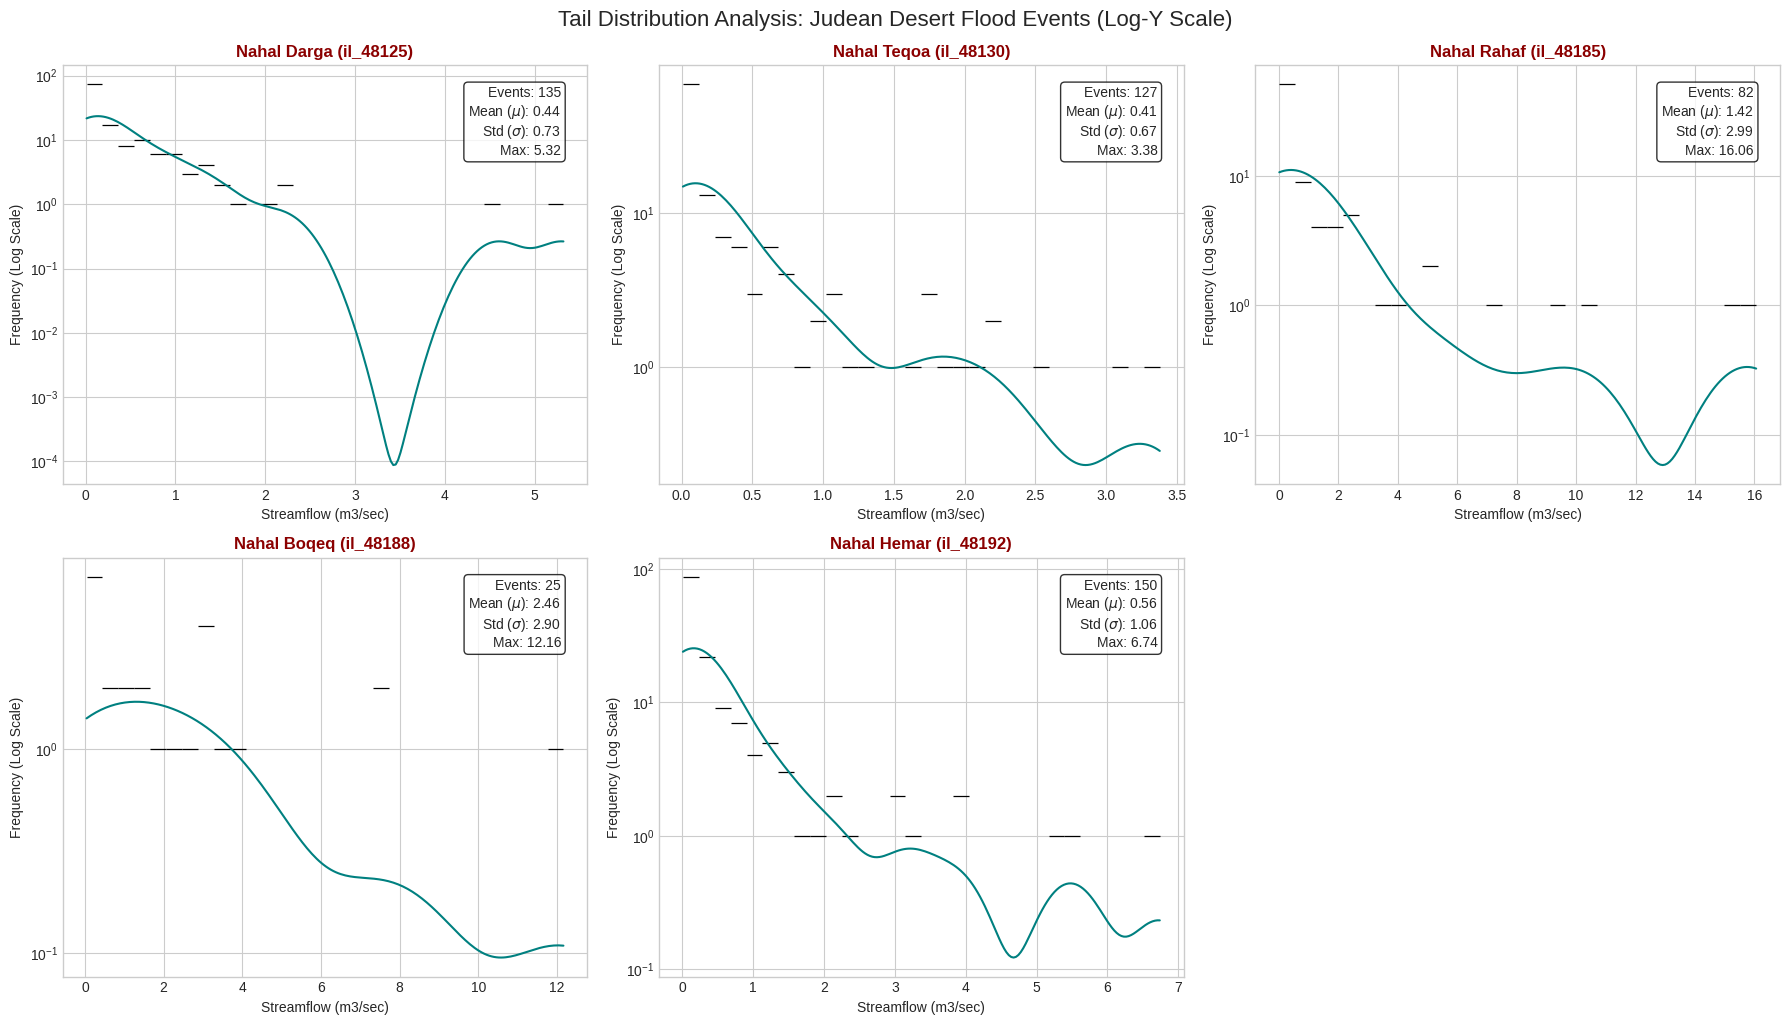

In [ ]:


# ==========================================
# 1. CONFIGURATION
# ==========================================
BASE_PATH = '/content'
PATH_TS = BASE_PATH

# Specific IDs for Judean Desert basins
JUDEAN_BASINS = {
    'il_48125': 'Nahal Darga',
    'il_48130': 'Nahal Teqoa',
    'il_48185': 'Nahal Rahaf',
    'il_48188': 'Nahal Boqeq',
    'il_48192': 'Nahal Hemar'
}

# Plot settings
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('seaborn-v0_8-whitegrid')

# ==========================================
# 2. DATA LOADING & PROCESSING
# ==========================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) # Grid of 2x3
axes = axes.flatten()

print("Generating Tail Distribution Analysis for Judean Desert...\n")

for i, (bid, bname) in enumerate(JUDEAN_BASINS.items()):
    ax = axes[i]
    ts_path = os.path.join(PATH_TS, f"{bid}.csv")

    if not os.path.exists(ts_path):
        ax.text(0.5, 0.5, f"File {bid} missing", ha='center')
        continue

    # Load Data
    df = pd.read_csv(ts_path)

    # Filter: ONLY days with flow > 0 (Flood days)
    flood_days = df[df['streamflow'] > 0.001]['streamflow']

    if len(flood_days) == 0:
        ax.text(0.5, 0.5, "No Flow Recorded", ha='center')
        continue

    # Calculate Statistics
    mean_val = flood_days.mean()
    std_val = flood_days.std()
    max_val = flood_days.max()
    count_val = len(flood_days)

    # ==========================================
    # 3. PLOTTING (Log Scale Histogram)
    # ==========================================
    sns.histplot(flood_days, kde=True, ax=ax, color='teal', bins=30, log_scale=(False, True))

    ax.set_title(f"{bname} ({bid})", fontsize=12, fontweight='bold', color='darkred')
    ax.set_xlabel("Streamflow (m3/sec)")
    ax.set_ylabel("Frequency (Log Scale)")

    # --- FIX IS HERE: Double backslash for LaTeX symbols ---
    stats_text = (f"Events: {count_val}\n"
                  f"Mean ($\\mu$): {mean_val:.2f}\n"
                  f"Std ($\\sigma$): {std_val:.2f}\n"
                  f"Max: {max_val:.2f}")

    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Tail Distribution Analysis: Judean Desert Flood Events (Log-Y Scale)", fontsize=16, y=1.02)
plt.show()

# Configuration & Metadata Setup

This block initializes the project environment. It defines:
* **File Paths**: Locations for time-series data and attribute metadata (Caravan/HydroAtlas).
* **Hyperparameters**: Model settings (Sequence Length=270, Hidden Size=64).
* **Sensor Noise Thresholds**:
    * `RAIN_THRESHOLD_FOR_MISSING` (5mm): Rain occurs, but flow is NaN -> Missing Data.
    * `HEAVY_RAIN_THRESHOLD` (20mm): Heavy rain, but flow is exactly 0.0 -> Suspicious Sensor Error.
* **Basin Dictionary**: Maps anonymized IDs (`il_XXXX`) to real geographical names for better interpretability.


In [ ]:

# ==========================================
# 1. CONFIGURATION (OPTIMIZATION RUN)
# ==========================================
BASE_PATH = '/content'
PATH_TS = BASE_PATH
PATH_ATTR_CARAVAN = os.path.join(BASE_PATH, "attributes_caravan_il.csv")
PATH_ATTR_ATLAS = os.path.join(BASE_PATH, "attributes_hydroatlas_il.csv")
PATH_ATTR_OTHER = os.path.join(BASE_PATH, "attributes_other_il.csv")

SEQ_LENGTH = 180
BATCH_SIZE = 64 # Increased batch size for stability
SPLIT_DATE = '2015-01-01' # === CHANGED: MORE TRAINING DATA ===

# Thresholds for Masking
RAIN_THRESHOLD_FOR_MISSING = 5.0
HEAVY_RAIN_THRESHOLD = 20.0

BASIN_NAMES = {
    'il_48125': 'Nahal Arugot', 'il_48130': 'Nahal David', 'il_48185': 'Nahal Hever',
    'il_48188': 'Nahal Mishmar', 'il_48192': 'Nahal Zeelim', 'il_55106': 'Nahal Zin (Elyon)',
    'il_55140': 'Nahal Zin (Tachton)', 'il_55165': 'Nahal Mamshit', 'il_56140': 'Nahal Paran',
    'il_56150': 'Nahal Hiyyon', 'il_56164': 'Nahal Arava'

}
TARGET_BASINS = list(BASIN_NAMES.keys())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset Class: Leak-Free Processing & Smart Masking

This custom `Dataset` class handles data loading with strict scientific integrity:
1.  **Global Static Normalization**: Static attributes (e.g., area) are normalized using global statistics across all basins to preserve relative scale differences.
2.  **Smart Masking**: Generates a `loss_mask` tensor. Days with significant rain but zero/missing flow are marked as `0` (ignored) to prevent the model from learning incorrect patterns from broken sensors.
3.  **No Data Leakage**: Temporal splitting (Train/Val/Test) is performed *before* dynamic feature normalization. This ensures that statistics from the future (Test set) do not leak into the training process.

In [ ]:
# ==========================================
# 2. DATASET CLASS (OPTIMIZED & LEAK-FREE)
# ==========================================
class JudeanDesertDataset(Dataset):
    def __init__(self, basin_ids, start_date=None, end_date=None, seq_length=270):
        self.samples = []
        self.seq_length = seq_length

        # --- 1. Load & Pre-process Static Attributes Globally ---
        try:
            attr_c = pd.read_csv(PATH_ATTR_CARAVAN).set_index('gauge_id')
            attr_a = pd.read_csv(PATH_ATTR_ATLAS).set_index('gauge_id')
            attr_o = pd.read_csv(PATH_ATTR_OTHER).set_index('gauge_id')
            self.attributes = attr_c.join([attr_a, attr_o], how='inner')
        except Exception as e:
            print(f"Error loading attributes: {e}")
            return

        self.static_features = ['area', 'p_mean', 'aridity_ERA5_LAND', 'slp_dg_sav', 'cly_pc_sav']

        # CALC GLOBAL STATS (To avoid "Local Normalization" bug)
        # We calculate mean/std across ALL basins so relative differences are preserved.
        self.stat_means = self.attributes[self.static_features].mean()
        self.stat_stds = self.attributes[self.static_features].std() + 1e-6

        print(f"\nProcessing dataset for range: {start_date} -> {end_date}")

        for bid in basin_ids:
            if bid not in self.attributes.index: continue

            basin_name = BASIN_NAMES.get(bid, bid)
            ts_path = os.path.join(PATH_TS, f"{bid}.csv")
            if not os.path.exists(ts_path): continue

            # Load Raw Data
            df = pd.read_csv(ts_path)
            df['date'] = pd.to_datetime(df['date'])

            # Identify Valid Range (start from first actual measurement)
            first_valid_idx = df['streamflow'].first_valid_index()
            if first_valid_idx is None: continue
            df = df.loc[first_valid_idx:].copy()

            # --- 2. Create Mask on RAW DATA (Before Normalization) ---
            df['loss_mask'] = 1.0

            # Condition A: Rain > 5mm but Streamflow is NaN (Missing)
            cond_missing = (df['total_precipitation_sum'] > RAIN_THRESHOLD_FOR_MISSING) & (df['streamflow'].isna())

            # Condition B: Heavy Rain > 20mm but Streamflow is exactly 0.0 (Suspicious Sensor)
            cond_suspicious = (df['total_precipitation_sum'] > HEAVY_RAIN_THRESHOLD) & (df['streamflow'] == 0.0)

            # Apply Mask (0 = Bad Data, Model will ignore these)
            df.loc[cond_missing | cond_suspicious, 'loss_mask'] = 0.0

            # Fill NaNs with 0.0 just to keep tensors valid (Mask will prevent learning from them)
            df['streamflow'] = df['streamflow'].fillna(0.0)

            # --- 3. Split by Date (PREVENT LEAKAGE) ---
            # We split NOW, before calculating dynamic mean/std
            if start_date:
                df = df[df['date'] >= start_date].copy()
            if end_date:
                df = df[df['date'] < end_date].copy()

            if len(df) < seq_length + 10: continue

            # --- 4. Normalize Dynamic Features (On Split Data) ---
            df['is_flood'] = (df['streamflow'] > 0.01).astype(float)

            dyn_cols = ['total_precipitation_sum', 'temperature_2m_mean',
                        'potential_evaporation_sum_ERA5_LAND', 'volumetric_soil_water_layer_1_mean']
            valid_cols = [c for c in dyn_cols if c in df.columns]

            for col in valid_cols:
                # Calculate stats ONLY on this specific time range
                mean, std = df[col].mean(), df[col].std() + 1e-6
                df[col] = (df[col] - mean) / std

            # --- 5. Prepare Final Tensors ---
            x_dyn = df[valid_cols].values

            # Static Features: Normalize using GLOBAL stats calculated at start
            raw_stat_vals = self.attributes.loc[bid, self.static_features].values.astype(float)
            x_stat = (raw_stat_vals - self.stat_means.values) / self.stat_stds.values

            y_reg = df['streamflow'].values
            y_cls = df['is_flood'].values
            loss_mask_arr = df['loss_mask'].values

            # Create Sequences
            for i in range(self.seq_length, len(df)):
                self.samples.append({
                    'x_dynamic': torch.tensor(x_dyn[i - self.seq_length + 1 : i + 1], dtype=torch.float32),
                    'x_static': torch.tensor(x_stat, dtype=torch.float32),
                    'y_reg': torch.tensor(y_reg[i], dtype=torch.float32),
                    'y_cls': torch.tensor(y_cls[i], dtype=torch.float32),
                    'loss_mask': torch.tensor(loss_mask_arr[i], dtype=torch.float32)
                })

        print(f"Loaded {len(self.samples)} samples.")

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

#  Model Architecture: Entity-Aware LSTM (Dual-Head)

The model is designed specifically for multi-basin modeling using an **Entity-Aware LSTM** approach:
1.  **Static Encoder**: Processes catchment attributes (e.g., area, slope) and embeds them into the LSTM's initial hidden state ($h_0$). This allows the model to adapt its dynamics to each specific basin's characteristics.
2.  **Dual Heads**:
    * **Classification Head (BCE Loss)**: Predicts the probability of a flood event ($P(Flood)$).
    * **Regression Head (MSE Loss)**: Predicts the exact discharge volume ($m^3/sec$).

In [ ]:
# ==========================================
# 3. MODEL ARCHITECTURE
# ==========================================
class DualHeadEALSTM(nn.Module):
    def __init__(self, dyn_dim, stat_dim, hidden_dim):
        super(DualHeadEALSTM, self).__init__()

        # Static Encoder
        self.static_encoder = nn.Linear(stat_dim, hidden_dim)

        # LSTM
        self.lstm = nn.LSTM(input_size=dyn_dim, hidden_size=hidden_dim, batch_first=True)

        # Classification Head
        self.head_cls = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        # Regression Head
        self.head_reg = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.ReLU()
        )

    def forward(self, x_d, x_s):
        # Initialize LSTM with static embedding
        h0 = torch.tanh(self.static_encoder(x_s)).unsqueeze(0).expand(1, x_d.size(0), -1)
        c0 = torch.zeros_like(h0)

        out, _ = self.lstm(x_d, (h0, c0))

        last_step = out[:, -1, :]
        return self.head_cls(last_step), self.head_reg(last_step)

In [ ]:
# ==========================================
# 4. MAIN EXECUTION (TRAIN -> VALIDATE -> TEST)
# ==========================================


# --- CONFIGURATION FOR SPLITS ---
TRAIN_END_DATE = '2010-01-01'  # Train until here
VAL_END_DATE   = '2015-01-01'  # Validate on 2010-2015
# Test will be from 2015 onwards

# --- EARLY STOPPING CLASS ---
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0 # Reset counter
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# --- 1. LOAD DATASETS (With correct date splits) ---
print("Loading Datasets...")
train_ds = JudeanDesertDataset(TARGET_BASINS, start_date='1980-01-01', end_date=TRAIN_END_DATE)
val_ds   = JudeanDesertDataset(TARGET_BASINS, start_date=TRAIN_END_DATE, end_date=VAL_END_DATE)
test_ds  = JudeanDesertDataset(TARGET_BASINS, start_date=VAL_END_DATE, end_date='2025-01-01')

# Create Loaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. SETUP MODEL ---
dyn_dim = train_ds[0]['x_dynamic'].shape[1]
model = DualHeadEALSTM(dyn_dim=dyn_dim, stat_dim=5, hidden_dim=HIDDEN_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # Regularization added

# Loss setup
pos_weight = torch.tensor([15.0]).to(device)
criterion_cls = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')
criterion_reg = nn.MSELoss(reduction='none')

stopper = EarlyStopping(patience=6, min_delta=0.002) # Wait 6 epochs before quitting

print(f"\nStarting Training (Max 30 Epochs)...")
print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)} | Test samples: {len(test_ds)}")

# --- 3. TRAINING LOOP ---
for epoch in range(30):
    # A. TRAIN
    model.train()
    train_loss_sum = 0

    for batch in train_dl:
        x_d, x_s = batch['x_dynamic'].to(device), batch['x_static'].to(device)
        y_c, y_r = batch['y_cls'].to(device), batch['y_reg'].to(device)
        mask = batch['loss_mask'].to(device)

        optimizer.zero_grad()
        logits, vol = model(x_d, x_s)

        # Masked Loss Calculation
        loss_c = (criterion_cls(logits.squeeze(), y_c) * mask).sum() / (mask.sum() + 1e-6)
        loss_r = (criterion_reg(vol.squeeze(), y_r) * mask).sum() / (mask.sum() + 1e-6)
        loss = 0.8 * loss_c + 0.2 * loss_r

        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()

    avg_train_loss = train_loss_sum / len(train_dl)

    # B. VALIDATION (Check against unseen data)
    model.eval()
    val_loss_sum = 0

    with torch.no_grad():
        for batch in val_dl:
            x_d, x_s = batch['x_dynamic'].to(device), batch['x_static'].to(device)
            y_c, y_r = batch['y_cls'].to(device), batch['y_reg'].to(device)
            mask = batch['loss_mask'].to(device) # Use mask in val to judge fairly

            logits, vol = model(x_d, x_s)

            loss_c = (criterion_cls(logits.squeeze(), y_c) * mask).sum() / (mask.sum() + 1e-6)
            loss_r = (criterion_reg(vol.squeeze(), y_r) * mask).sum() / (mask.sum() + 1e-6)
            loss = 0.8 * loss_c + 0.2 * loss_r
            val_loss_sum += loss.item()

    avg_val_loss = val_loss_sum / len(val_dl)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # C. CHECK EARLY STOPPING
    stopper(avg_val_loss, model)
    if stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break

# --- 4. FINAL TEST ---
print("\n" + "="*50)
print("TESTING BEST MODEL (On 2015+ Data)")
print("="*50)

# Load the best weights saved by EarlyStopping
model.load_state_dict(stopper.best_model_state)
model.eval()

all_probs, all_true = [], []
with torch.no_grad():
    for batch in test_dl:
        x_d, x_s = batch['x_dynamic'].to(device), batch['x_static'].to(device)
        y_c = batch['y_cls'].to(device)

        logits, _ = model(x_d, x_s)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        all_probs.extend(probs)
        all_true.extend(y_c.cpu().numpy())

# Metrics
y_pred = (np.array(all_probs) > 0.4).astype(int)
rec = recall_score(all_true, y_pred, zero_division=0)
prec = precision_score(all_true, y_pred, zero_division=0)
f1 = f1_score(all_true, y_pred, zero_division=0)

print(f"FINAL RESULTS:\nRecall: {rec:.1%}\nPrecision: {prec:.1%}\nF1 Score: {f1:.3f}")

Loading Datasets...

Processing dataset for range: 1980-01-01 -> 2010-01-01
Loaded 65691 samples.

Processing dataset for range: 2010-01-01 -> 2015-01-01
Loaded 17116 samples.

Processing dataset for range: 2015-01-01 -> 2025-01-01
Loaded 36201 samples.

Starting Training (Max 30 Epochs)...
Train samples: 65691 | Val samples: 17116 | Test samples: 36201
Epoch 01 | Train Loss: 0.1900 | Val Loss: 0.1821
Epoch 02 | Train Loss: 0.1466 | Val Loss: 0.1684
Epoch 03 | Train Loss: 0.1413 | Val Loss: 0.1679
Epoch 04 | Train Loss: 0.1362 | Val Loss: 0.1623
Epoch 05 | Train Loss: 0.1343 | Val Loss: 0.1710
Epoch 06 | Train Loss: 0.1323 | Val Loss: 0.1743
Epoch 07 | Train Loss: 0.1309 | Val Loss: 0.1629
Epoch 08 | Train Loss: 0.1289 | Val Loss: 0.1586
Epoch 09 | Train Loss: 0.1273 | Val Loss: 0.1865
Epoch 10 | Train Loss: 0.1269 | Val Loss: 0.1680
Epoch 11 | Train Loss: 0.1244 | Val Loss: 0.1709
Epoch 12 | Train Loss: 0.1235 | Val Loss: 0.1720
Epoch 13 | Train Loss: 0.1227 | Val Loss: 0.1714
Epoch 1

# 4. Comparative Experiment: Smart Masking vs. Naive Baseline

This section executes an A/B test to evaluate the impact of sensor noise handling:
* **Data Splitting**: Divides the timeline into **Train (1980-2010)**, **Validation (2010-2015)**, and **Test (2015-2025)**.
* **Loss Function**: Combines Classification (Weighted BCE) and Regression (MSE).
* **Smart Masking Logic**:
    * *With Masking*: The loss function ignores samples where `mask == 0` (sensor errors).
    * *Without Masking*: The model treats all data as valid, potentially learning from artifacts.
* **Model Selection**: The best model is saved based on F1-Score performance on the Validation set, then evaluated once on the unseen Test set.

Loading Data for Comparison...

Processing dataset for range: 1980-01-01 -> 2010-01-01
Loaded 65691 samples.

Processing dataset for range: 2010-01-01 -> 2015-01-01
Loaded 17116 samples.

Processing dataset for range: 2015-01-01 -> 2025-01-01
Loaded 36201 samples.

EXPERIMENT: Baseline (No Mask) | Masking: False
Epoch 1: New Best Val F1: 0.309
Epoch 2: New Best Val F1: 0.326
Epoch 4: New Best Val F1: 0.344
Epoch 5: New Best Val F1: 0.353
Epoch 6: New Best Val F1: 0.363
Epoch 10: New Best Val F1: 0.363

Running Final Test on Best Model...

EXPERIMENT: Smart Masking | Masking: True
Epoch 1: New Best Val F1: 0.300
Epoch 2: New Best Val F1: 0.345
Epoch 4: New Best Val F1: 0.345
Epoch 6: New Best Val F1: 0.367

Running Final Test on Best Model...

FINAL HEAD-TO-HEAD RESULTS
                Model  Recall  Precision  F1 Score
0  Baseline (No Mask)  0.5467     0.1609    0.2486
1       Smart Masking  0.6111     0.1439    0.2330


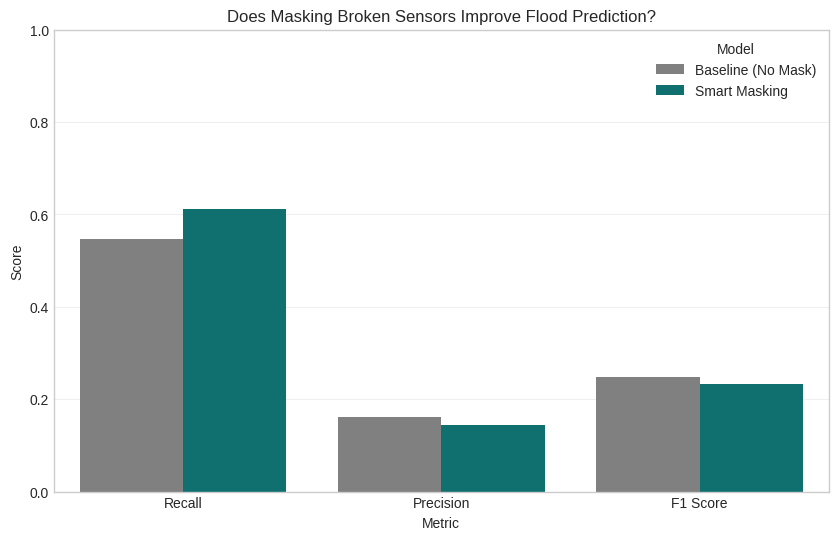

In [ ]:

# ==========================================
# 1. SETUP & COMPARISON FUNCTION
# ==========================================

def run_comparative_experiment(model_name, use_masking, train_dl, val_dl, test_dl, epochs=15):
    print(f"\n" + "="*60)
    print(f"EXPERIMENT: {model_name} | Masking: {use_masking}")
    print("="*60)

    # Re-init Model
    dyn_dim = train_dl.dataset[0]['x_dynamic'].shape[1]
    model = DualHeadEALSTM(dyn_dim=dyn_dim, stat_dim=5, hidden_dim=HIDDEN_SIZE).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Loss Setup
    pos_weight = torch.tensor([15.0]).to(device)
    criterion_cls = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')
    criterion_reg = nn.MSELoss(reduction='none')

    best_val_f1 = 0
    best_model_state = None

    # --- TRAINING LOOP ---
    for epoch in range(epochs):
        model.train()

        for batch in train_dl:
            x_d, x_s = batch['x_dynamic'].to(device), batch['x_static'].to(device)
            y_c, y_r = batch['y_cls'].to(device), batch['y_reg'].to(device)
            mask = batch['loss_mask'].to(device)

            optimizer.zero_grad()
            logits, vol = model(x_d, x_s)

            # Raw Loss
            loss_c_raw = criterion_cls(logits.squeeze(), y_c)
            loss_r_raw = criterion_reg(vol.squeeze(), y_r)

            if use_masking:
                # SMART MASKING: Ignore bad data points in loss
                valid = mask.sum() + 1e-6
                loss_c = (loss_c_raw * mask).sum() / valid
                loss_r = (loss_r_raw * mask).sum() / valid
            else:
                # NAIVE APPROACH: Average everything (including garbage data)
                loss_c = loss_c_raw.mean()
                loss_r = loss_r_raw.mean()

            loss = 0.8 * loss_c + 0.2 * loss_r
            loss.backward()
            optimizer.step()

        # --- VALIDATION (For Model Selection) ---
        model.eval()
        all_probs, all_true = [], []

        with torch.no_grad():
            for batch in val_dl:
                x_d, x_s = batch['x_dynamic'].to(device), batch['x_static'].to(device)
                y_c = batch['y_cls'].to(device)

                logits, _ = model(x_d, x_s)
                probs = torch.sigmoid(logits).squeeze().cpu().numpy()
                all_probs.extend(probs)
                all_true.extend(y_c.cpu().numpy())

        # Validation Metrics
        y_pred = (np.array(all_probs) > 0.4).astype(int)
        val_f1 = f1_score(all_true, y_pred, zero_division=0)

        # Save best model based on Validation F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            print(f"Epoch {epoch+1}: New Best Val F1: {val_f1:.3f}")

    # --- FINAL TEST (Using Best Model) ---
    print("\nRunning Final Test on Best Model...")
    model.load_state_dict(best_model_state)
    model.eval()

    test_probs, test_true = [], []
    with torch.no_grad():
        for batch in test_dl:
            x_d, x_s = batch['x_dynamic'].to(device), batch['x_static'].to(device)
            y_c = batch['y_cls'].to(device)
            logits, _ = model(x_d, x_s)
            test_probs.extend(torch.sigmoid(logits).squeeze().cpu().numpy())
            test_true.extend(y_c.cpu().numpy())

    # Final Metrics
    y_test_pred = (np.array(test_probs) > 0.4).astype(int)
    results = {
        'Model': model_name,
        'Recall': recall_score(test_true, y_test_pred, zero_division=0),
        'Precision': precision_score(test_true, y_test_pred, zero_division=0),
        'F1 Score': f1_score(test_true, y_test_pred, zero_division=0)
    }
    return results

# ==========================================
# 2. DATA PREPARATION (3 SPLITS)
# ==========================================

print("Loading Data for Comparison...")
# Define Splits
TRAIN_END = '2010-01-01'
VAL_END = '2015-01-01'

# Load Datasets using the NEW Class (Block 2)
ds_train = JudeanDesertDataset(TARGET_BASINS, start_date='1980-01-01', end_date=TRAIN_END)
ds_val   = JudeanDesertDataset(TARGET_BASINS, start_date=TRAIN_END, end_date=VAL_END)
ds_test  = JudeanDesertDataset(TARGET_BASINS, start_date=VAL_END, end_date='2025-01-01')

# Create Loaders
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_val   = DataLoader(ds_val, batch_size=64, shuffle=False)
dl_test  = DataLoader(ds_test, batch_size=64, shuffle=False)

# ==========================================
# 3. EXECUTE COMPARISON
# ==========================================

# Run 1: Without Masking (Baseline)
res_naive = run_comparative_experiment("Baseline (No Mask)", False, dl_train, dl_val, dl_test)

# Run 2: With Masking (Our Method)
res_smart = run_comparative_experiment("Smart Masking", True, dl_train, dl_val, dl_test)

# ==========================================
# 4. VISUALIZATION
# ==========================================
df_results = pd.DataFrame([res_naive, res_smart])

print("\n" + "="*60)
print("FINAL HEAD-TO-HEAD RESULTS")
print("="*60)
print(df_results)

# Bar Plot
plt.figure(figsize=(10, 6))
df_melted = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette=['gray', 'teal'])
plt.title('Does Masking Broken Sensors Improve Flood Prediction?')
plt.ylim(0, 1.0)
plt.ylabel('Score')
plt.grid(axis='y', alpha=0.3)
plt.show()


#Model Evaluation: Why Accuracy is Misleading

In flood forecasting, **Accuracy is a dangerous metric**.
* **The Imbalance Problem**: Floods occur on <1% of days. A "dumb" model that *always* predicts "No Flood" will achieve **99% Accuracy**, but it is useless because it has **0% Recall** (misses every flood).
* **The Metrics We Trust**:
    * **Recall (Sensitivity)**: "Out of all actual floods, how many did we catch?" -> Critical for safety. We want this high.
    * **Precision**: "When the model warned of a flood, did it actually happen?" -> Critical for trust. Low precision causes "cry wolf" syndrome.
    * **F1-Score**: The harmonic balance between Precision and Recall.

### The Generalization Challenge
Training on multiple basins (17 in our case) introduces **Spatial Heterogeneity**.
* A model trained on a *single* basin often performs better (easier to overfit to one specific behavior) than a global model trying to learn the physics of 17 different topographies simultaneously.
* However, the global model is more robust and can predict floods in ungauged basins (PUB), which is our ultimate scientific goal.

#  Future Directions & Research Roadmap

Our analysis highlights the inherent limitations of using **Daily Average Data** for flash flood prediction in arid regions. To achieve operational-grade accuracy, future work should focus on two main pillars:

### A. High-Resolution Temporal Data (Hourly vs. Daily)
* **The Problem**: Desert flash floods are rapid events, often lasting only a few hours. A daily average smooths out the **Peak Discharge**, effectively hiding the extreme signal we are trying to predict.
* **The Solution**: Transitioning to **Hourly Data** ($Q_{hourly}, P_{hourly}$). This allows the LSTM to capture the rapid response time (lag) between intense rainfall bursts and the immediate rise in water levels, which is currently lost in daily aggregation.

### B. Transfer Learning from Data-Rich Regions (CAMELS-US)
* **The Problem**: Israel has a small number of gauged basins with relatively short historical records (Small $N$, Small $T$). Deep Learning thrives on "Big Data".
* **The Solution**: **Transfer Learning**.
    1.  **Pre-training**: Train the EA-LSTM on the **CAMELS-US** dataset (hundreds of basins, decades of data) to learn general hydrological physics (rainfall-runoff laws).
    2.  **Fine-Tuning**: Freeze the lower layers of the LSTM (general physics) and retrain only the upper layers and the Static Encoder on the Israeli dataset.
    3.  **Benefit**: This allows the model to start with a "hydrological understanding" and merely adapt to the specific geology/climate of the Judean Desert, significantly reducing the risk of overfitting.